<center><h1>Final Project</h1></center>
<br>
<br>

Name: Jinwen "Eddie" Zhao
<br>
Github Username: jinwenz2024
<br>
USC ID: 7666343953

## 1. Text Classification

It is highly recommended that you complete this project using Keras and Python.

### (a)
In this problem, we are trying to build a classifier to analyze the sentiment of
reviews. You are provided with text data in two folders: one folder involves
positive reviews, and one folder involves negative reviews.

In [1]:
# keras.io. Tokenizer API, pad_sequences
# Tensorflow: https://www.tensorflow.org/
# Install Keras and tensorflow
# pip install keras
# pip install tensorflow
# pip install -q --upgrade keras-nlp

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
#import keras_nlp
from tensorflow.keras.preprocessing.text import Tokenizer
import glob
import string
import re
import matplotlib.pyplot as plt
from joblib import dump, load
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Dropout, Conv1D, MaxPooling1D, LSTM

### Data Exploration and Pre-processing
i. You can use binary encoding for the sentiments , i.e y = 1 for positive sentiments and y = −1 for negative sentiments.

ii. The data are pretty clean. Remove the punctuation and numbers from the
data.

In [3]:
# Data cleaning by removing numbers and puntuations.
def clean_txt(text):    # Assisted by ChatGPT
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuations
    text = text.replace('\n', ' ')  # Replace newlines
    text = re.sub(r'\d+', '', text)   # Remove numbers
    text = ' '.join(text.split())  # Remove leading, trailing, and extra spaces
    return text

iii. The name of each text file starts with cv number. Use text files 0-699 in each
class for training and 700-999 for testing.

In [4]:
# Read the texts from both pos and neg folders
pos_train_path = '../data/pos/train'
pos_test_path = '../data/pos/test'
neg_train_path = '../data/neg/train'
neg_test_path = '../data/neg/test'

# Use text files 0-699 in each class for training and 700-999 for testing. The train/test files are already seperated in different folders.

# Read all txt files in a given folder (Assisted by ChatGPT)
def read_txt(folder_path):
    txt_list = []
    txt_files = glob.glob(os.path.join(folder_path, '*.txt'))
    for file_path in txt_files:
        with open(file_path, 'r') as file:
            text = file.read()
            cleaned_text = clean_txt(text)
            txt_list.append(cleaned_text)
    return txt_list

pos_train = read_txt(pos_train_path)
pos_test = read_txt(pos_test_path)
neg_train = read_txt(neg_train_path)
neg_test = read_txt(neg_test_path)

iv. Count the number of unique words in the whole dataset (train + test) and
print it out.

In [5]:
X_train = pos_train + neg_train
y_train = [1 for i in range(len(pos_train))] + [0 for i in range(len(neg_train))]  # 1: positive   0: negative
X_test = pos_test + neg_test
y_test = [1 for i in range(len(pos_test))] + [0 for i in range(len(neg_test))]

df_train = pd.DataFrame({
    'text': pos_train + neg_train,
    'mood': [1 for i in range(len(pos_train))] + [0 for i in range(len(neg_train))]  # 1: positive   0: negative
})
df_test = pd.DataFrame({
    'text': pos_test + neg_test,
    'mood': [1 for i in range(len(pos_test))] + [0 for i in range(len(neg_test))]
})
df = pd.concat([df_train, df_test], ignore_index=True)

X = df['text']
y = df['mood']

In [6]:
# Create tokenizer (from the snippet of code given in the final project)
t = Tokenizer()

# Fit the tokenizers on the documents
t.fit_on_texts(X)   # Takes in a list of strings

# Summarize what was learned
print('Word count (show first 15):')
unique_word_count = t.word_counts
print(list(unique_word_count.items())[:15]) # "OrderedDict([('films', 2103), ('adapted', 45), ('from', 4986), ('comic', 375), ('books', 81), ('have', 4899), ('had', 1544), ('plenty', 129), ('of', 33971), ('success', 216), ('whether', 216), ('theyre', 414), ('about', 3518), ('superheroes', 12), ('batman', 195), ('superman', 23), ('spawn', 75), ...")
print('\nNumber of unique words:', len(unique_word_count)) 

#print('Document count:', t.document_count)
#print('Word Index:', t.word_index)
#print('Word_docs:', word_docs)

# Integer encode documents
#encoded_docs = t.text_to_matrix(X, mode = 'count')
#print('\nEncoded Document:', encoded_docs)

Word count (show first 15):
[('films', 2103), ('adapted', 45), ('from', 4986), ('comic', 375), ('books', 81), ('have', 4899), ('had', 1544), ('plenty', 129), ('of', 33971), ('success', 216), ('whether', 216), ('theyre', 414), ('about', 3518), ('superheroes', 12), ('batman', 195)]

Number of unique words: 46830


v. Calculate the average review length and the standard deviation of review
lengths. Report the results.

In [7]:
file_len_list = []
for file in X:
    #file_len_list.append(len(file))    # Append the character count
    file_len_list.append(len(file.split()))  # Append the word count per file
print('Average review length (in terms of character counts):', np.mean(file_len_list))
print('Standard deviation of review length:', np.std(file_len_list))

Average review length (in terms of character counts): 644.3555
Standard deviation of review length: 284.97987142910637


vi. Plot the histogram of review lengths.

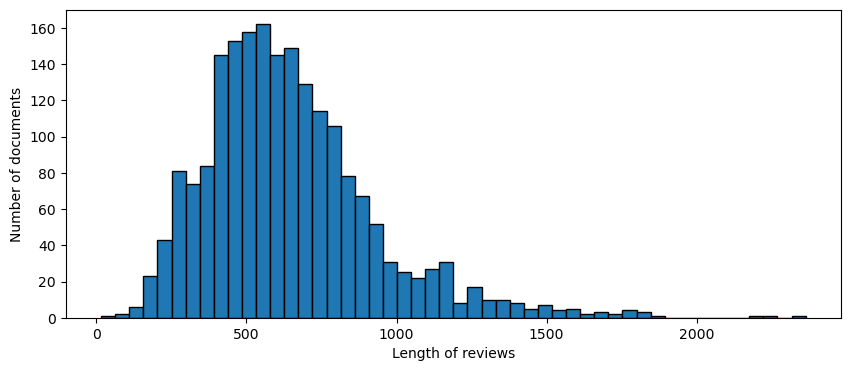

In [8]:
# Show histogram of document length
plt.figure(figsize = (10, 4))
plt.hist(file_len_list, bins = 50, edgecolor = 'black')
plt.xlabel('Length of reviews')
plt.ylabel('Number of documents')
plt.show()

vii. To represent each text (= data point), there are many ways. In NLP/Deep
Learning terminology, this task is called tokenization. It is common to represent text using popularity/ rank of words in text. The most common word
in the text will be represented as 1, the second most common word will be
represented as 2, etc. Tokenize each text document using this method.

In [9]:
word_indexes = t.word_index
print(list(word_indexes.items())[:15])  # Show the 15 most frequent words

[('the', 1), ('a', 2), ('and', 3), ('of', 4), ('to', 5), ('is', 6), ('in', 7), ('that', 8), ('it', 9), ('as', 10), ('with', 11), ('for', 12), ('his', 13), ('this', 14), ('film', 15)]


viii. Select a review length L that 70% of the reviews have a length below it. If
you feel more adventurous, set the threshold to 90%.

In [10]:
df1 = df.copy()
df1['Length'] = file_len_list
df1_sorted = df1.sort_values(by = ['Length'], ascending=False)
# df1_sorted

# Select a review length L that 70% of the reviews have a length below it.
len_threshold = 0.7
L = (df1_sorted.iloc[[int(len(df1_sorted) * (1 - len_threshold))]])['Length'].values[0]
L

737

ix. Truncate reviews longer than L words and zero-pad reviews shorter than L
so that all texts (= data points) are of length L.

In [11]:
def truncate_pad(X, L = 737):   # texts: the list of strings of texts. X in this case
    # Reference: https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences
    texts = list(X)
    t = Tokenizer()  # Most common 50 words  # t = Tokenizer(num_words=5000)
    t.fit_on_texts(texts)
    sequences = t.texts_to_sequences(texts)  # Obtaining the sequence. Assisted by ChatGPT
    sequences_padded = pad_sequences(sequences, maxlen = L, truncating = 'post', padding = 'post')   # footnote 3
    return sequences_padded

# Test
Test_text = [
    "hi im saul goodman",
    "hi im saul goodman did you know that you have rights",
    "hi im"
]
truncate_pad(Test_text, L = 5)   # Each list is its own document

array([[1, 2, 3, 4, 0],
       [1, 2, 3, 4, 6],
       [1, 2, 0, 0, 0]])

In [12]:
X_train_pad = truncate_pad(X_train)
X_test_pad = truncate_pad(X_test)

### (c) Word Embeddings

i. Assume that we are interested in the top 5,000 words. This means that in each integer sequence that
represents each document, we set to zero those integers that represent words
that are not among the top 5,000 words in the document.
Choose the length
of the embedding vector for each word to be 32. Hence, each document is
represented as a 32 × L matrix.

In [13]:
# Initialize the Kera sequential model 
# Reference: https://www.tensorflow.org/text/guide/word_embeddings
            #https://www.tensorflow.org/guide/keras/sequential_model
            #https://keras.io/api/layers/core_layers/embedding/
model = Sequential()    
model.add(Embedding(input_dim=5000+1, output_dim=32, input_length=L))   # L = 737

C:\Users\13352\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


ii. Flatten the matrix of each document to a vector

In [14]:
model.add(Flatten())

### (d) Multi-Layer Perceptron

i. Train a MLP with three (dense) hidden layers each of which has 50 ReLUs
and one output layer with a single sigmoid neuron. Use a dropout rate of
20% for the first layer and 50% for the other layers. Use ADAM optimizer
and binary cross entropy loss (which is equivalent to having a softmax in the
output). To avoid overfitting, just set the number of epochs as 2. Use a batch
size of 10.

In [15]:
# Reference: https://www.tensorflow.org/guide/keras/sequential_model
# https://keras.io/guides/sequential_model/
# https://www.youtube.com/watch?v=kyktbJpg2mU Keras sequential video tutorial by Dr. Data Science

# Build the 3-layer perceptron model using sigmoid activation function
model.add(Dense(50, activation="relu", name = 'hidden_layer1'))
model.add(Dropout(0.2))   # Dropout is a regularization. Drop 20% of the neurons
model.add(Dense(50, activation="relu", name = 'hidden_layer2'))
model.add(Dropout(0.5))
model.add(Dense(50, activation="relu", name = 'hidden_layer3'))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid", name = 'output_layer'))

In [16]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
# Convert the words with index above 5000 to 0
X_train_pad[X_train_pad > 5000] = 0
#X_train_pad = np.array(X_train_pad)
X_test_pad[X_test_pad > 5000] = 0
#X_test_pad = np.array(X_test_pad)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [18]:
# We also need to hand-pick some words that doesn't contribute to the sentiments. 
#print(word_indexes)
def drop_words(X_pad):
    moodless_words = ['the', 'a', 'and', 'of', 'to', 'is', 'in', 'that', 'as', 'with', 'this', 'on', 'are', 'by', 'be', 'movie', 
                      'we', 'it', 'i', 'his', 'her', 'he', 'she', 'film']
    # Add words if needed
    moodless_index_list = [word_indexes[word] for word in moodless_words if word in word_indexes]
    for i, sequence in enumerate(X_pad):   # enumerate: turn list into indexed lists. Assisted by ChatGPT
        for j, word_index in enumerate(sequence):
            if word_index in moodless_index_list:
                X_pad[i][j] = 0
    return X_pad
X_train_pad = drop_words(X_train_pad)
X_test_pad = drop_words(X_test_pad)
# X_test_pad[:5, :5]

In [19]:
# Fit the model
model.fit(X_train_pad, y_train, epochs = 2, batch_size = 10)  # X_train_pad should be a padded sequence matrix

# Save the model
dump(model, '../models/model.joblib')

Epoch 1/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4454 - loss: 0.7081
Epoch 2/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5312 - loss: 0.6925


['../models/model.joblib']

In [20]:
# Load the model from local files
model = load('../models/model.joblib')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (10, 737, 32)          │       160,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (10, 23584)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (10, 50)               │     1,179,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (10, 50)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (10, 50)               │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (10, 50)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (10, 50)               │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (10, 50)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (10, 1)                │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,033,301 (15.39 MB)

 Trainable params: 1,344,433 (5.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,688,868 (10.26 MB)

ii. Report the train and test accuracies of this model

In [21]:
train_loss, train_accuracy = model.evaluate(X_train_pad, y_train)
print("Train Accuracy:", train_accuracy)

# Evaluate the model on testing data
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test)
print("Test Accuracy:", test_accuracy)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8147 - loss: 0.6300 
Train Accuracy: 0.7685714364051819
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6046 - loss: 0.6803 
Test Accuracy: 0.5383333563804626


### (e) One-Dimensional Convolutional Neural Network:

Although CNNs are mainly used for image data, they can also be applied to text
data, as text also has adjacency information. Keras supports one-dimensional
convolutions and pooling by the Conv1D and MaxPooling1D classes respectively.

i. After the embedding layer, insert a Conv1D layer. This convolutional layer
has 32 feature maps , and each of the 32 kernels has size 3, i.e. reads embedded
word representations 3 vector elements of the word embedding at a time. The
convolutional layer is followed by a 1D max pooling layer with a length and
stride of 2 that halves the size of the feature maps from the convolutional
layer. The rest of the network is the same as the neural network above.

In [22]:
# Reonstruct the model 
model1 = Sequential([
    Embedding(input_dim=5000+1, output_dim=32, input_length=L),
    Conv1D(filters=32, kernel_size=3, activation='relu'),  
        # Reference: https://keras.io/api/layers/convolution_layers/convolution1d/
        # Reference: https://stackoverflow.com/questions/69591717/how-is-the-keras-conv1d-input-specified-i-seem-to-be-lacking-a-dimension answer by AloneTogether
    MaxPooling1D(pool_size=2, strides=2),
        # Reference: https://keras.io/api/layers/pooling_layers/max_pooling1d/
    Flatten(),
    Dense(50, activation='relu', name = 'hidden_layer1'),
    Dropout(0.2),  # 20% dropout
    Dense(50, activation='relu', name = 'hidden_layer2'),
    Dropout(0.5),  # 50% dropout
    Dense(50, activation='relu', name = 'hidden_layer3'),
    Dropout(0.5),  # 50% dropout
    Dense(1, activation='sigmoid', name = 'output_layer')
])
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model1.fit(X_train_pad, y_train, epochs = 2, batch_size = 10)   # Too high of epochs can overfit (100% train acc but 50% test acc)

# Save the model
dump(model1, '../models/model1.joblib')

Epoch 1/2


C:\Users\13352\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5051 - loss: 0.6973
Epoch 2/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5600 - loss: 0.6865


['../models/model1.joblib']

In [23]:
# Load the model
model1 = load('../models/model1.joblib')
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (10, 737, 32)          │       160,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (10, 735, 32)          │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (10, 367, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (10, 11744)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (10, 50)               │       587,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (10, 50)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (10, 50)               │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (10, 50)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (10, 50)               │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (10, 50)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (10, 1)                │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,266,613 (8.65 MB)

 Trainable params: 755,537 (2.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,511,076 (5.76 MB)

ii. Report the train and test accuracies of this model

In [24]:
train_loss, train_accuracy = model1.evaluate(X_train_pad, y_train)
print("Train Accuracy:", train_accuracy)

# Evaluate the model on testing data
test_loss, test_accuracy = model1.evaluate(X_test_pad, y_test)
print("Test Accuracy:", test_accuracy)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7383 - loss: 0.6095 
Train Accuracy: 0.7021428346633911
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6145 - loss: 0.6580 
Test Accuracy: 0.54666668176651


### (f) Long Short-Term Memory Recurrent Neural Network

The structure of the LSTM we are going to use is shown in the following figure

i. Each word is represented to LSTM as a vector of 32 elements and the LSTM
is followed by a dense layer of 256 ReLUs. Use a dropout rate of 0.2 for both LSTM and the dense layer. Train the model using 10-50 epochs and batch
size of 10.

In [25]:
# Reference: https://www.youtube.com/watch?v=wY0dyFgNCgY LSTM video by Jeff Heaton
# https://keras.io/api/layers/recurrent_layers/lstm/
# https://towardsdatascience.com/a-practical-guide-to-rnn-and-lstm-in-keras-980f176271bc

LSTM_model = Sequential([
    Embedding(input_dim = 5000 + 1, output_dim = 32, input_length = L),
    #Flatten(),
    LSTM(32),
    Dropout(0.2),
    Dense(256, activation = 'relu', name = 'dense_layer'),
    Dropout(0.2),
    Dense(1, activation = 'sigmoid', name = 'output_layer')
])
LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
LSTM_model.fit(X_train_pad, y_train, epochs = 20, batch_size = 10)

Epoch 1/20


C:\Users\13352\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.5043 - loss: 0.6934
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.5126 - loss: 0.6907
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - accuracy: 0.5924 - loss: 0.6889
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.6401 - loss: 0.5966
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.6553 - loss: 0.5653
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - accuracy: 0.6689 - loss: 0.5316
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.6739 - loss: 0.5165
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.6715 - loss: 0.4857
Epoch 9/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.7001 - loss: 0.4726
Epoch 10/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - accuracy: 0.6740 - loss: 0.5339
Epoch 11/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.6782 - loss: 0.4741
Epoch 12/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 

ii. Report the train and test accuracies of this model.

In [26]:
# Save the model
dump(LSTM_model, '../models/LSTM_model.joblib')

['../models/LSTM_model.joblib']

In [27]:
# Load back the models 
LSTM_model = load('../models/LSTM_model.joblib')
LSTM_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (10, 737, 32)          │       160,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (10, 32)               │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (10, 32)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer (Dense)             │ (10, 256)              │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (10, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (10, 1)                │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 531,173 (2.03 MB)

 Trainable params: 177,057 (691.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 354,116 (1.35 MB)

In [28]:
train_loss, train_accuracy = LSTM_model.evaluate(X_train_pad, y_train)
print("Train Accuracy:", train_accuracy)

# Evaluate the model on testing data
test_loss, test_accuracy = LSTM_model.evaluate(X_test_pad, y_test)
print("Test Accuracy:", test_accuracy)

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4630 - loss: 0.4817
Train Accuracy: 0.6821428537368774
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3416 - loss: 1.1962
Test Accuracy: 0.5249999761581421


In [29]:
# LSTM but with more layers to see if accuracy improves:
LSTM_model2 = Sequential([
    Embedding(input_dim = 5000 + 1, output_dim = 32, input_length = L),
    #Flatten(),
    LSTM(32),
    Dropout(0.2),
    Dense(256, activation = 'relu', name = 'dense_layer'),
    Dropout(0.2),
    Dense(256, activation = 'relu', name = 'dense_layer2'),
    Dropout(0.2),
    Dense(1, activation = 'sigmoid', name = 'output_layer')
])
LSTM_model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
LSTM_model2.fit(X_train_pad, y_train, epochs = 20, batch_size = 10)
# Save the model
dump(LSTM_model2, '../models/LSTM_model2.joblib')

Epoch 1/20


C:\Users\13352\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - accuracy: 0.4824 - loss: 0.6938
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.5122 - loss: 0.6925
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.6137 - loss: 0.6297
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 93ms/step - accuracy: 0.6720 - loss: 0.5611
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 95ms/step - accuracy: 0.6782 - loss: 0.5277
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step - accuracy: 0.6834 - loss: 0.4906
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.6920 - loss: 0.4828
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step - accuracy: 0.6817 - loss: 0.4718
Epoch 9/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.6850 - loss: 0.4619
Epoch 10/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 95ms/step - accuracy: 0.6908 - loss: 0.4575
Epoch 11/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step - accuracy: 0.7001 - loss: 0.4613
Epoch 12/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 

['../models/LSTM_model2.joblib']

In [30]:
LSTM_model2 = load('../models/LSTM_model2.joblib')   # This is a model with 2 layers (for experiment to see if accuracy improves)
train_loss, train_accuracy = LSTM_model2.evaluate(X_train_pad, y_train)
print("Train Accuracy:", train_accuracy)

# Evaluate the model on testing data
test_loss, test_accuracy = LSTM_model2.evaluate(X_test_pad, y_test)
print("Test Accuracy:", test_accuracy)

# The accurarcy didnt improve significantly

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4720 - loss: 0.4980
Train Accuracy: 0.6892856955528259
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3523 - loss: 1.4368
Test Accuracy: 0.5216666460037231


# References:

* keras.io
* https://www.tensorflow.org/
* Pad Sequence documentation: https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences
* https://www.tensorflow.org/guide/keras/sequential_model
* Word Embedding documentation: https://www.tensorflow.org/text/guide/word_embeddings
* https://www.youtube.com/watch?v=kyktbJpg2mU Keras sequential video tutorial by Dr. Data Science
* https://keras.io/api/layers/core_layers/embedding/
* Convolution documentation: https://keras.io/api/layers/convolution_layers/convolution1d/
* Convolution reference https://stackoverflow.com/questions/69591717/how-is-the-keras-conv1d-input-specified-i-seem-to-be-lacking-a-dimension by AloneTogether
* Max pooling id: https://keras.io/api/layers/pooling_layers/max_pooling1d/
* LSTM https://www.youtube.com/watch?v=wY0dyFgNCgY LSTM video by Jeff Heaton
* LSTM documentation https://keras.io/api/layers/recurrent_layers/lstm/
* LSTM reference: https://towardsdatascience.com/a-practical-guide-to-rnn-and-lstm-in-keras-980f176271bc
* ChatGPT by OpenAI